<a href="https://colab.research.google.com/github/Suryaranji/Pytorch/blob/main/Children%20vs%20Adults/CUSTOM_DataSET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing torch and check version

In [1]:
import torch
from torch import nn
torch.__version__

'2.0.1+cu118'

#Setting up device Agostic Code

In [2]:
device="cuda" if torch.cuda.is_available() else 'cpu'
device

'cuda'

#Importing `Dataset` From Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import requests
import zipfile
import shutil
from pathlib import Path
path=Path('data/')
imagepath=path/"child_vs_grownup"


imagepath.mkdir(parents=True,exist_ok=True)
shutil.copy2("/content/drive/MyDrive/DataSet.zip",imagepath/"Dataset.zip")
print("file Downloading")



file Downloading


## Extracting files

In [5]:
with zipfile.ZipFile(imagepath/"Dataset.zip",'r') as ref:
  print("Extracting")
  ref.extractall(imagepath/"dataset")

Extracting


In [6]:
import os

for dirpath,dirnames,files in os.walk(imagepath):
  print(f"There are {len(dirnames)} directories and files of length({len(files)}) in {dirpath}")

There are 1 directories and files of length(1) in data/child_vs_grownup
There are 2 directories and files of length(0) in data/child_vs_grownup/dataset
There are 2 directories and files of length(0) in data/child_vs_grownup/dataset/train
There are 0 directories and files of length(340) in data/child_vs_grownup/dataset/train/adults
There are 0 directories and files of length(340) in data/child_vs_grownup/dataset/train/children
There are 2 directories and files of length(0) in data/child_vs_grownup/dataset/test
There are 0 directories and files of length(60) in data/child_vs_grownup/dataset/test/adults
There are 0 directories and files of length(60) in data/child_vs_grownup/dataset/test/children


In [7]:
train=imagepath/"dataset/train"
test=imagepath/"dataset/test"
train,test

(PosixPath('data/child_vs_grownup/dataset/train'),
 PosixPath('data/child_vs_grownup/dataset/test'))

#Visualize Data using PIL

adults


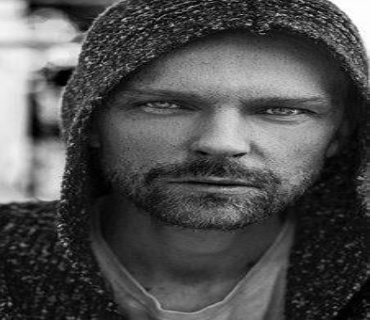

In [8]:
from PIL import  Image
import random
'''


 pIL is a Python Image Library
 which has image module
 Image :- Has Open() method takes image path as a parameter
'''
imglist=list(imagepath.glob("*/*/*/*.jpg"))
pathofimage=random.choice(imglist)
image_class=pathofimage.parent.stem

image=Image.open(pathofimage)
print(image_class)
image

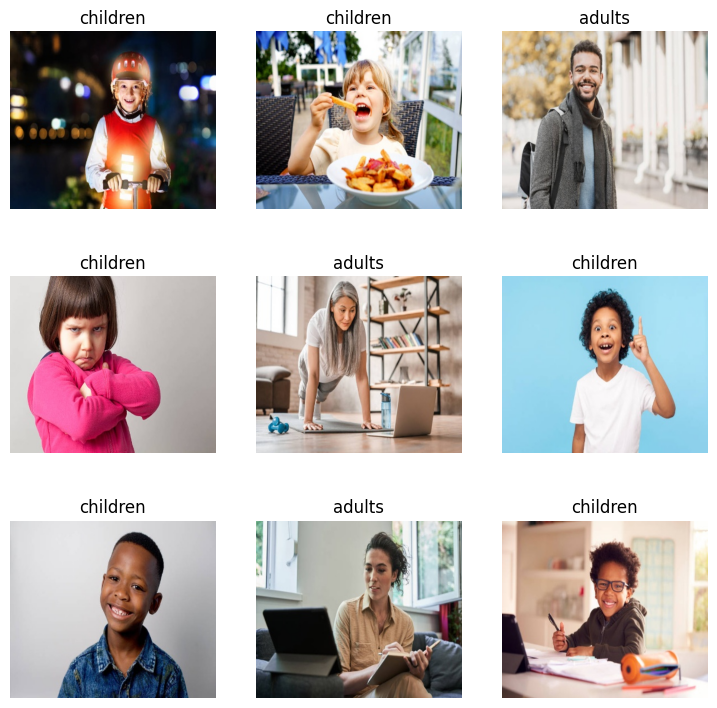

In [9]:
import matplotlib.pyplot as plt
import numpy  as np
row=3
col=3
plt.figure(figsize=(9,9))
for i  in range(1,row*col+1):
  imgpath=random.choice(imglist)
  img=Image.open(imgpath)
  image=np.asarray(img)
  plt.subplot(row,col,i)
  plt.imshow(image)
  plt.title(imgpath.parent.stem)
  plt.axis(False)

#Tranformation of images into tensors Using `Transforms`

In [10]:
from torchvision import datasets,transforms
import random

In [11]:
transform=transforms.Compose([ # compose take a list of transformations
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
    ]
)


#Transform visualiZation

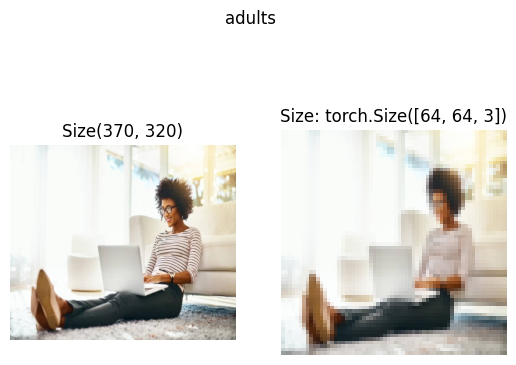

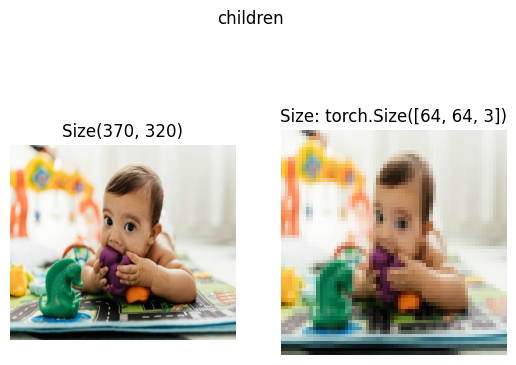

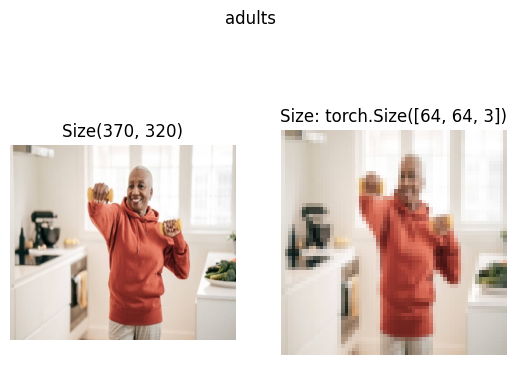

In [12]:
def transform_visualization_raw(path:Path,
                            transform:transforms,
                            randomseed:int ,
                            number_of_images:int):
  """
  This tranform_visualization function takes an image in the path and transform them to tensors

  Args:- * Path of the images
         * Transform function
         * Random seed
         * Number of images to visualize
  Returns: None
  Shows The original image vs transformed image
  """
  torch.manual_seed(randomseed)
  images=random.sample(list(path),k=number_of_images)
  for img in images:
    with Image.open(img) as image:
      fig, ax=plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(image)
      ax[0].set_title(f"Size{image.size}")
      ax[0].axis("off")

      #tranformed image
      transformed_image=transform(image).permute(1,2,0)
      # permute to make colour channels last for matplotlip visualiztion
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Size: {transformed_image.shape}")
      ax[1].axis("off")
      fig.suptitle(img.parent.stem)

transform_visualization_raw(imglist,transform,40,3)


#MAking train and test Dataset using torchvision imageFolder

In [13]:
from torchvision import datasets


In [14]:
train_data=datasets.ImageFolder(
    root=train,
    transform=transform#transformation
)
test_data=datasets.ImageFolder(
    root=test,#path
    transform=transform
)
train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 680
     Root location: data/child_vs_grownup/dataset/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 120
     Root location: data/child_vs_grownup/dataset/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

(-0.5, 63.5, 63.5, -0.5)

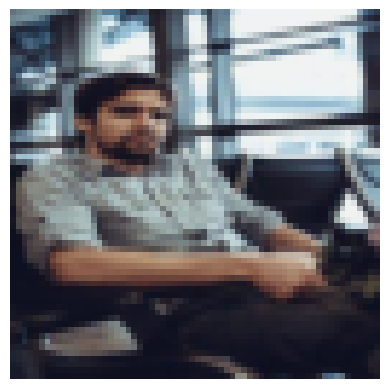

In [15]:
img,label=train_data[0]
img.shape,label
plt.imshow(img.permute(1,2,0))
plt.axis(False)

In [16]:
train_data.classes,train_data.class_to_idx

(['adults', 'children'], {'adults': 0, 'children': 1})

In [17]:
classes=train_data.classes

In [18]:
len(train_data),len(test_data)

(680, 120)

#Make data into dataloaders


In [19]:
from torch.utils.data import DataLoader

In [20]:
train_data_loader=DataLoader(dataset=train_data,
                             batch_size=10,
                             shuffle=True)
test_data_loader=DataLoader(dataset=test_data,
                            batch_size=10,
                            shuffle=False)
len(train_data_loader),len(test_data_loader)

(68, 12)

In [21]:
lis=next(iter(train_data_loader))
lis[0][0].shape

torch.Size([3, 64, 64])

#Dataloader Visulaization function(visualizing_data(data))

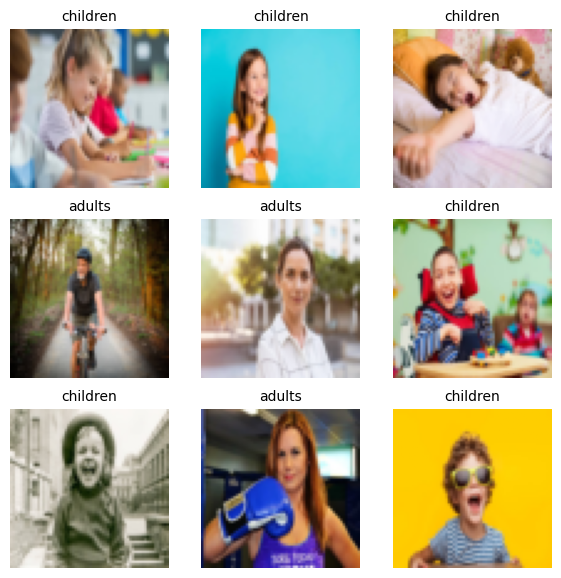

In [22]:
def visualizing_data(data:torch.utils.data.DataLoader):

  """
     This function takes dataloader as an arguments then shows 9 different images in the list
     Args:- Dataloader
     Returns :-None
  """

  plt.figure(figsize=(7,7))
  img,label=next(iter(data))
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(img[i].permute(1,2,0))
    plt.title(classes[label[i]],{
        'fontsize':10
    })
    plt.axis("off")
visualizing_data(train_data_loader)

#Recreating Image Folder

In [23]:
import os

classes=[i.name for i in os.scandir(train)]
classes

['adults', 'children']

In [24]:
def getclasses(path:path):
  """
  this function return a  list of classes and a dictionary of vlaues attached to classes
  """
  classes=sorted([i.name for i in os.scandir(path)])
  if  not classes:
    raise FileNotFoundError("No file path exist...")
  class_to_idx={clas :i for i,clas in enumerate(classes)}
  return classes,class_to_idx

In [25]:
getclasses(train)

(['adults', 'children'], {'adults': 0, 'children': 1})

In [26]:
from PIL import Image

In [27]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  def __init__(self,root:path,transform=None):
    self.path=list(root.glob("*/*.jpg"))
    self.transform=transform
    self.classes,self.class_to_idx=getclasses(root
                                              )
  def loadImage(self,index):
    img=Image.open(self.path[index])
    return img
  def __len__(self):
    return len(self.path)
  def __getitem__(self,index):
    img=self.loadImage(index)
    clas=self.path[index].parent.name
    class_index=self.class_to_idx[clas]


    if(transform is not None):
      return transform(img),class_index
    return img,class_index

In [28]:
train_custom_data=ImageFolderCustom(train,transform)
train_custom_data==train_data


False

In [29]:
train_custom_data.class_to_idx

{'adults': 0, 'children': 1}

#Model 0

## Dataset and dataLoaders For Model0

###Dataset

In [30]:
from torchvision import datasets

In [31]:
train_dataset=datasets.ImageFolder(root=train,transform=transform)

test_dataset=datasets.ImageFolder(root=test,transform=transform)

len(train_dataset),len(test_dataset),train_dataset[0]

(680,
 120,
 (tensor([[[0.4000, 0.4118, 0.4196,  ..., 0.2667, 0.2000, 0.1725],
           [0.4314, 0.4510, 0.4627,  ..., 0.1765, 0.1490, 0.1294],
           [0.3961, 0.3529, 0.2941,  ..., 0.3059, 0.2824, 0.2471],
           ...,
           [0.0902, 0.1098, 0.1373,  ..., 0.0706, 0.1294, 0.1333],
           [0.0863, 0.0902, 0.1294,  ..., 0.0588, 0.1059, 0.1255],
           [0.0941, 0.0941, 0.1098,  ..., 0.0588, 0.0706, 0.0980]],
  
          [[0.4431, 0.4902, 0.5216,  ..., 0.3882, 0.2941, 0.2275],
           [0.5216, 0.5451, 0.5647,  ..., 0.2196, 0.1569, 0.1294],
           [0.4784, 0.4235, 0.3569,  ..., 0.3882, 0.3529, 0.3137],
           ...,
           [0.1137, 0.1255, 0.1490,  ..., 0.0784, 0.1216, 0.1176],
           [0.1059, 0.1059, 0.1412,  ..., 0.0667, 0.1020, 0.1137],
           [0.1020, 0.1020, 0.1176,  ..., 0.0667, 0.0745, 0.0941]],
  
          [[0.4941, 0.5412, 0.5686,  ..., 0.5059, 0.3922, 0.3098],
           [0.5608, 0.5882, 0.6118,  ..., 0.2980, 0.2314, 0.1922],
          

In [32]:
import os
from torch.utils.data import DataLoader
os.cpu_count()

2

###DataLoaders





In [33]:
BatchSize=10

workers=os.cpu_count()


train_data_loader=DataLoader(dataset=train_dataset,batch_size=BatchSize,shuffle=True,num_workers=workers)

test_data_loader=DataLoader(dataset=test_dataset,batch_size=BatchSize,num_workers=workers)


len(train_data_loader),len(test_data_loader)


(68, 12)

In [34]:
from torch import nn

##Tiny VGG Model Recreation

In [35]:
class Model0(nn.Module):
  def __init__(self,input,hidden,output):
    super().__init__()

    self.block1=nn.Sequential(
        nn.Conv2d(in_channels=input,out_channels=hidden,kernel_size=2,stride=1,padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden,out_channels=hidden,kernel_size=2,stride=1,padding=0),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.block2=nn.Sequential(
        nn.Conv2d(in_channels=hidden,out_channels=hidden,kernel_size=2,stride=1,padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden,out_channels=hidden,kernel_size=2,stride=1,padding=0),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.finalLayer=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden*14*14,out_features=output)
    )
  def forward(self,x):
    x=self.block1(x)

    x=self.block2(x)

    x=self.finalLayer(x)

    return x

In [36]:
model0=Model0(input=3,hidden=10,output=1)
model0

Model0(
  (block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (finalLayer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1960, out_features=1, bias=True)
  )
)

In [37]:
img=torch.randn(1,3,64,64)

pred=model0(img)
pred.shape
pred


tensor([[0.1141]], grad_fn=<AddmmBackward0>)

In [38]:
probs=torch.softmax(pred,dim=1)#makes the values in the range between 0 and 1 and those values sum to 1
torch.argmax(probs,dim=1).item()

0

In [39]:
14*14*10

1960

In [40]:
lis=next(iter(train_data_loader))
model=Model0(3,10,1)
model=model.to(device)
lis[0],lis[1]=lis[0].to(device),lis[1].to(device)
pred=model(lis[0]).squeeze()
pred

tensor([-0.0480, -0.0506, -0.0547, -0.0609, -0.0707, -0.0487, -0.0757, -0.0721,
        -0.0458, -0.0559], device='cuda:0', grad_fn=<SqueezeBackward0>)

###Summary of model



In [41]:
try :
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo


In [42]:
torchinfo.summary(model0,input=[1,3,64,64])

Layer (type:depth-idx)                   Param #
Model0                                   --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       130
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       410
│    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-5                       410
│    └─ReLU: 2-6                         --
│    └─Conv2d: 2-7                       410
│    └─MaxPool2d: 2-8                    --
├─Sequential: 1-3                        --
│    └─Flatten: 2-9                      --
│    └─Linear: 2-10                      1,961
Total params: 3,321
Trainable params: 3,321
Non-trainable params: 0

###Accuracy Function

In [43]:
try:
  import torchmetrics
except:
  !pip install torchmetrics
  import torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 12.7 MB/s eta 0:00:00


In [44]:
from torchmetrics import Accuracy
accuracy=Accuracy(task='binary',num_classes=2)

###Training Loop

In [45]:
def training(data:torch.utils.data.DataLoader,
             model:torch.nn.Module,
             device,
             accuracy:Accuracy,
             loss_fn,
             Optimizer:torch.optim):
  trainloss,trainaccuracy=0,0
  for x,y in data:
    x,y=x.to(device),y.to(device)
    y_pred=model(x).squeeze()
    loss=loss_fn(y_pred,y.float())
    trainloss+=loss
    trainaccuracy+=accuracy(y,torch.round(torch.sigmoid(y_pred)))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return trainloss/len(data),trainaccuracy/len(data)

###testing loop

In [46]:
def testing(data:torch.utils.data.DataLoader,
            model:torch.nn.Module,
            loss_fn,
            accuracy,device):

  model.eval()

  with torch.inference_mode():
    testloss,testaccuracy=0,0
    for x,y in data:
      x,y=x.to(device),y.to(device)
      y_pred=model(x).squeeze()
      loss=loss_fn(y_pred,y.float())
      testloss+=loss
      testaccuracy+=accuracy(y,torch.round(torch.sigmoid(y_pred)))
  return testloss/len(test_data_loader),testaccuracy/len(test_data_loader)

In [47]:

def model_building(train_data:torch.utils.data.DataLoader,
                   test_data:torch.utils.data.DataLoader,
                   model:torch.nn.Module,
                   loss_fn,
                   optimizer:torch.optim,
                   accuracy,
                   device,
                   epochs):
  results={
      'trainloss':[],
      'testloss':[],
      'trainaccuracy':[],
      'testaccuracy':[]
  }
  for epoch in range(epochs):
    print(f"Epoch{epoch}-----------------------------------------")
    trainloss,trainaccuracy=training(train_data,model,device,accuracy,loss_fn,optimizer)

    testloss,testaccuracy =testing(test_data,model,loss_fn,accuracy,device)

    print(f"trainloss : {trainloss}  | trainaccuracy : {trainaccuracy}")
    print(f"testloss : {testloss}  | testaccuracy : {testaccuracy}")
    results['trainloss'].append(trainloss.item())
    results['testloss'].append(testloss.item())
    results['trainaccuracy'].append(trainaccuracy.item())
    results['testaccuracy'].append(testaccuracy.item())
  return results


In [48]:
##Setting up device agnostic code

device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [49]:
#training
from timeit import default_timer as timer
model=Model0(3,10,1)
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=0.001)
accuracy=accuracy.to(device)
start=timer()

mode=model.to(device)
results=model_building(train_data_loader,test_data_loader,model,loss_fn,optimizer,accuracy,device,5)

end=timer()

print("total time",end-start)

Epoch0-----------------------------------------
trainloss : 0.6969174146652222  | trainaccuracy : 0.4926469922065735
testloss : 0.6945909857749939  | testaccuracy : 0.5
Epoch1-----------------------------------------
trainloss : 0.6917885541915894  | trainaccuracy : 0.5250000357627869
testloss : 0.6868854761123657  | testaccuracy : 0.5583333969116211
Epoch2-----------------------------------------
trainloss : 0.6741089820861816  | trainaccuracy : 0.5882354378700256
testloss : 0.7049278616905212  | testaccuracy : 0.5583333373069763
Epoch3-----------------------------------------
trainloss : 0.6603854894638062  | trainaccuracy : 0.6014705300331116
testloss : 0.6916490793228149  | testaccuracy : 0.5583333373069763
Epoch4-----------------------------------------
trainloss : 0.651211678981781  | trainaccuracy : 0.6102941632270813
testloss : 0.6896304488182068  | testaccuracy : 0.5583333373069763
total time 12.463716717000011


In [50]:
results

{'trainloss': [0.6969174146652222,
  0.6917885541915894,
  0.6741089820861816,
  0.6603854894638062,
  0.651211678981781],
 'testloss': [0.6945909857749939,
  0.6868854761123657,
  0.7049278616905212,
  0.6916490793228149,
  0.6896304488182068],
 'trainaccuracy': [0.4926469922065735,
  0.5250000357627869,
  0.5882354378700256,
  0.6014705300331116,
  0.6102941632270813],
 'testaccuracy': [0.5,
  0.5583333969116211,
  0.5583333373069763,
  0.5583333373069763,
  0.5583333373069763]}

###plotting loss Curves

In [51]:
results.keys()

dict_keys(['trainloss', 'testloss', 'trainaccuracy', 'testaccuracy'])

In [52]:
import matplotlib.pyplot as plt

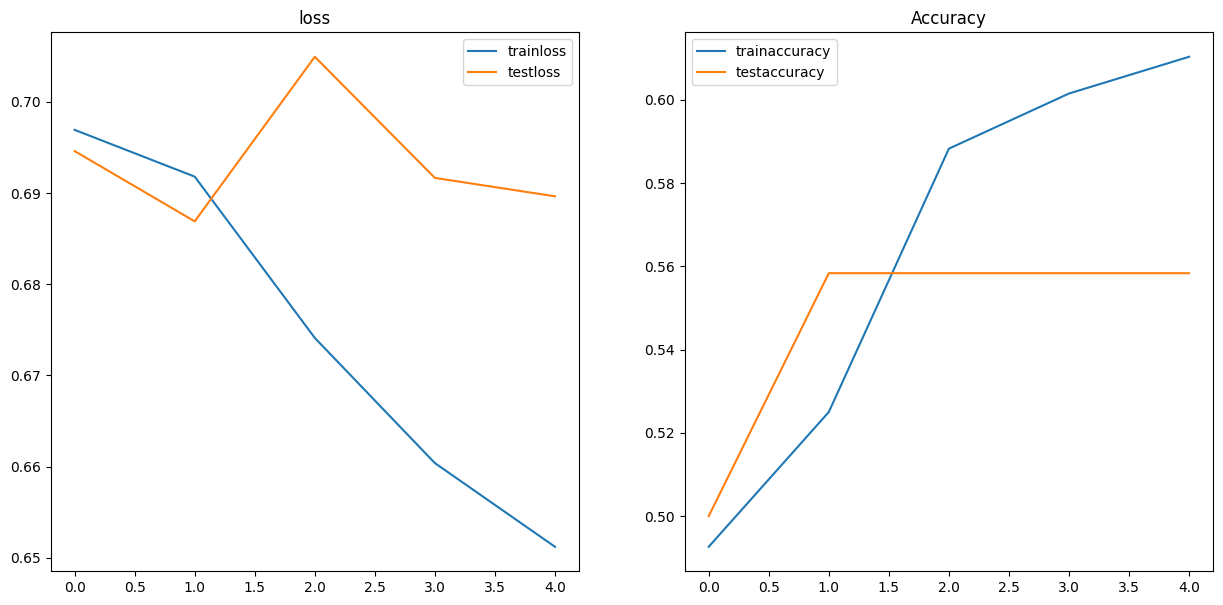

In [53]:
def plot_loss_curves(results:dict):
  plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  epoch=range(len(results['trainloss']))
  plt.plot(epoch,results['trainloss'],label="trainloss")
  plt.plot(epoch,results['testloss'],label="testloss")
  plt.title("loss")
  plt.legend()
  plt.subplot(1,2,2)

  plt.plot(epoch,results['trainaccuracy'],label="trainaccuracy")
  plt.plot(epoch,results['testaccuracy'],label="testaccuracy")
  plt.title("Accuracy")
  plt.legend()
plot_loss_curves(results)

#Model1(with Augmentation)

##dataset

In [54]:
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms

In [55]:
#transform
transform=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(31),
    transforms.ToTensor()
])

In [56]:
train_dataset=datasets.ImageFolder(root=train,transform=transform)
test_dataset=datasets.ImageFolder(root=test,transform=transform)
len(train_dataset),len(test_dataset)

(680, 120)

In [57]:
train_dataset[0][0].shape

torch.Size([3, 64, 64])

In [58]:
classes=train_dataset.classes

##visualization

In [59]:
def transform_visualization(data:datasets,
                            randomseed:int ,
                            number_of_images:int):
  """
  This tranform_visualization function takes an image in the path and transform them to tensors
  """
  torch.manual_seed(randomseed)
  data=random.sample(list(data),number_of_images)
  plt.figure(figsize=(15,7))
  for i,(img,label) in enumerate(data):
      plt.subplot(4,4,i+1)
      plt.imshow(img.permute(1,2,0))
      plt.title(f"Size{image.size}|{classes[label]}")
      plt.axis("off")


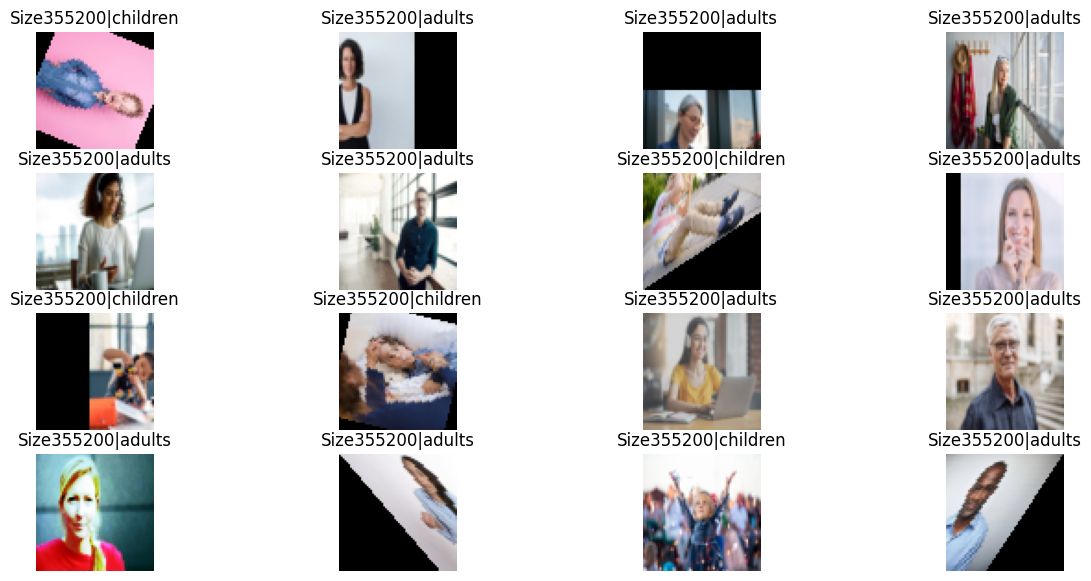

In [60]:
transform_visualization(train_dataset,40,16)

In [61]:
num_workers=os.cpu_count()
batch_size=10
train_data_loader=DataLoader(dataset=train_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=True)
test_data_loader=DataLoader(dataset=test_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=True)
len(train_data_loader),len(test_data_loader)

(68, 12)

In [62]:
from timeit import default_timer as timer
start=timer()
model1=Model0(3,30,1)
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(model1.parameters(),lr=0.1)
results1=model_building(train_data_loader,test_data_loader,model,loss_fn,optimizer,accuracy,device,epochs=5)
end=timer()
end-start

Epoch0-----------------------------------------
trainloss : 0.6688637137413025  | trainaccuracy : 0.6044117212295532
testloss : 0.6775164008140564  | testaccuracy : 0.5916666984558105
Epoch1-----------------------------------------
trainloss : 0.6809355020523071  | trainaccuracy : 0.5588235855102539
testloss : 0.7068633437156677  | testaccuracy : 0.5083333849906921
Epoch2-----------------------------------------
trainloss : 0.6868297457695007  | trainaccuracy : 0.561764657497406
testloss : 0.7452949285507202  | testaccuracy : 0.5333333611488342
Epoch3-----------------------------------------
trainloss : 0.6847925186157227  | trainaccuracy : 0.5691176056861877
testloss : 0.7097639441490173  | testaccuracy : 0.5333333015441895
Epoch4-----------------------------------------
trainloss : 0.676305890083313  | trainaccuracy : 0.5941176414489746
testloss : 0.7137898802757263  | testaccuracy : 0.5666666626930237


11.657294957999994

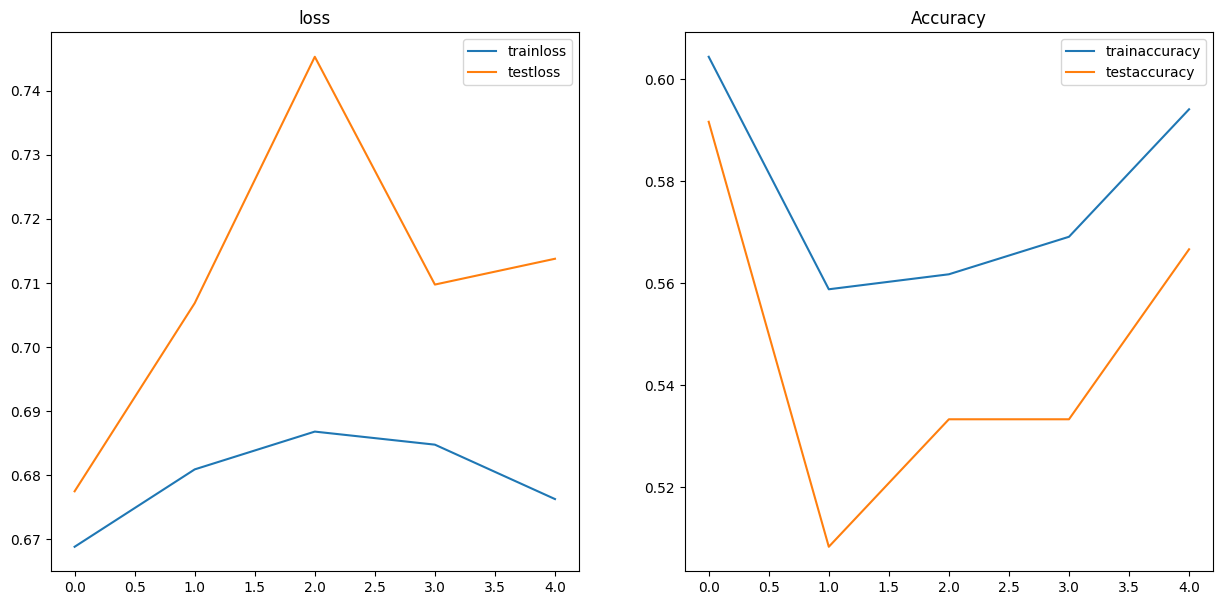

In [63]:
plot_loss_curves(results1)

Text(0.5, 0.98, 'Model1')

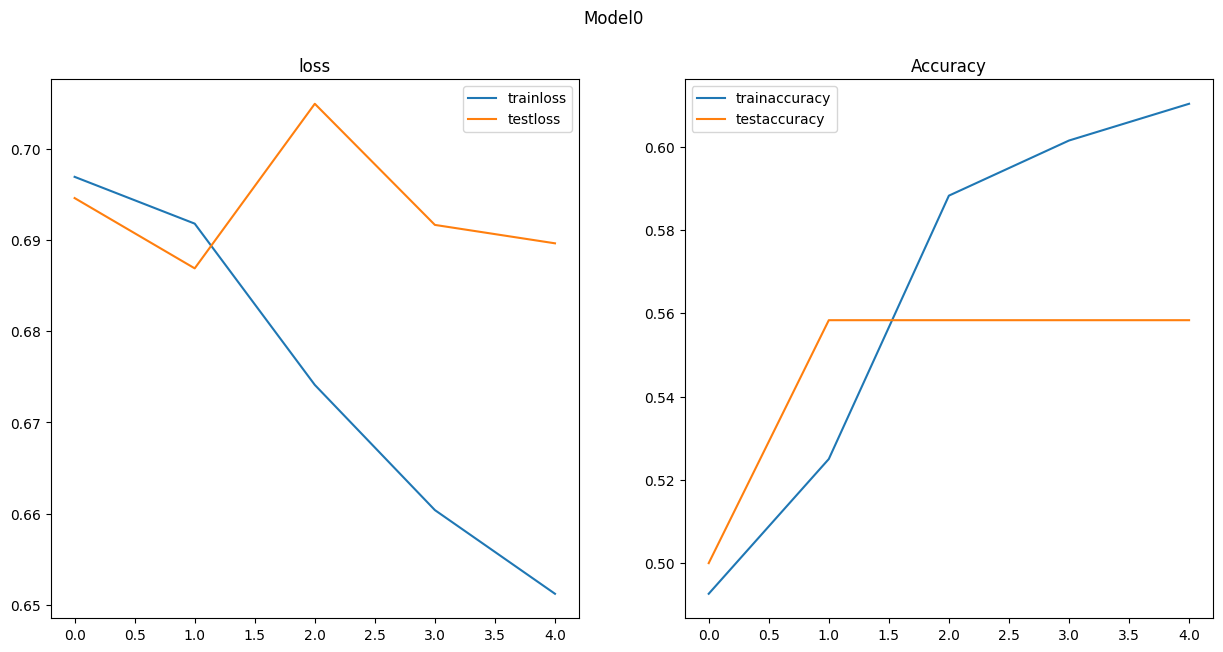

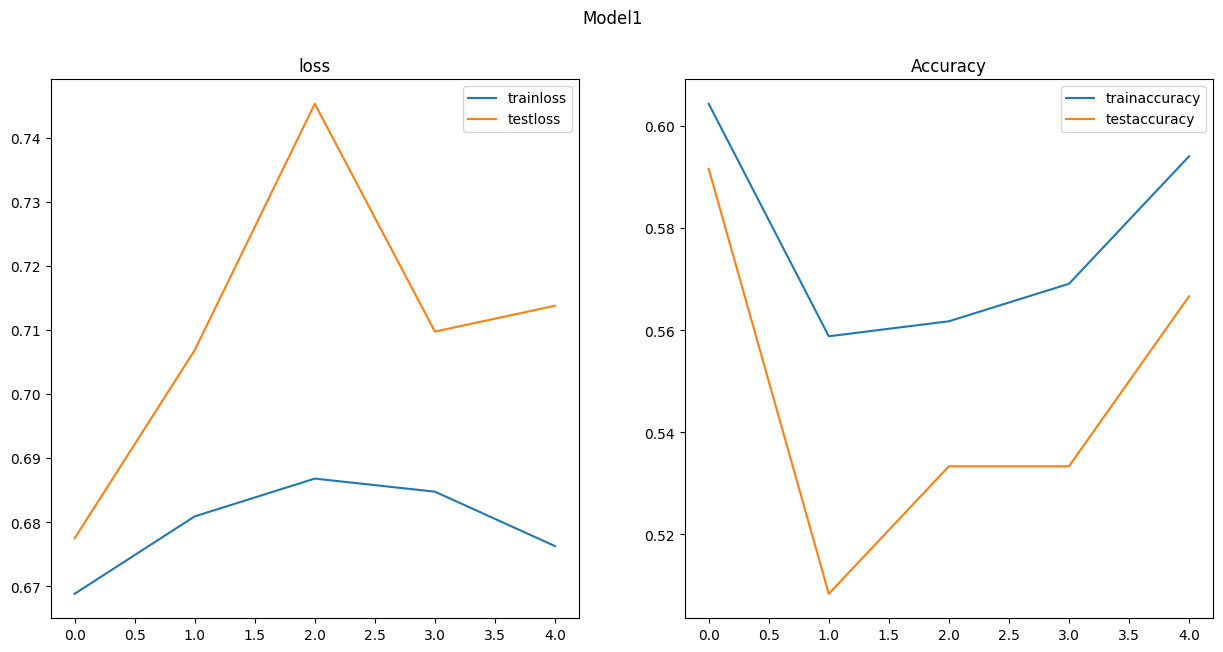

In [64]:
##Compare Models




plot_loss_curves(results)
plt.suptitle("Model0")

plot_loss_curves(results1)
plt.suptitle("Model1")

#Make prediction on custom image

In [65]:
import requests
from pathlib import Path
data=Path("data/")
Imagepath=data/"men1.jpg";

if not Imagepath.is_file():

  with open(Imagepath,"wb")as f:
    print("Downloading....")
    request=requests.get("https://www.stryx.com/cdn/shop/articles/man-looking-attractive.jpg?v=1666662774")
    f.write(request.content)
else:
  print("File Already Exist...  ")


Downloading....


#Using 'io_read' Method to load image
* this method turn a jpeg or png images into tensor image range from[0,255]RGB.

In [66]:
import torchvision
image=torchvision.io.read_image(str(Imagepath))
image

tensor([[[234, 234, 234,  ..., 249, 249, 249],
         [234, 234, 234,  ..., 249, 249, 249],
         [234, 234, 234,  ..., 249, 249, 249],
         ...,
         [210, 210, 210,  ..., 216, 215, 215],
         [210, 210, 210,  ..., 216, 215, 215],
         [210, 210, 210,  ..., 216, 215, 214]],

        [[169, 169, 169,  ..., 187, 187, 187],
         [169, 169, 169,  ..., 187, 187, 187],
         [169, 169, 169,  ..., 187, 187, 187],
         ...,
         [146, 146, 146,  ..., 152, 151, 151],
         [146, 146, 146,  ..., 152, 151, 151],
         [146, 146, 146,  ..., 152, 151, 150]],

        [[111, 111, 111,  ..., 126, 126, 126],
         [111, 111, 111,  ..., 128, 128, 128],
         [111, 111, 111,  ..., 128, 128, 128],
         ...,
         [ 84,  84,  84,  ...,  91,  90,  90],
         [ 84,  84,  84,  ...,  91,  90,  90],
         [ 84,  84,  84,  ...,  91,  90,  89]]], dtype=torch.uint8)

In [67]:
print(image.dtype)
print(image.shape)

torch.uint8
torch.Size([3, 667, 1000])


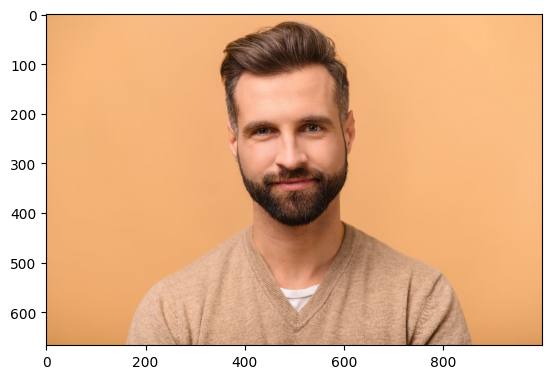

In [68]:
plt.imshow((image.to(float)/255).permute(1,2,0))

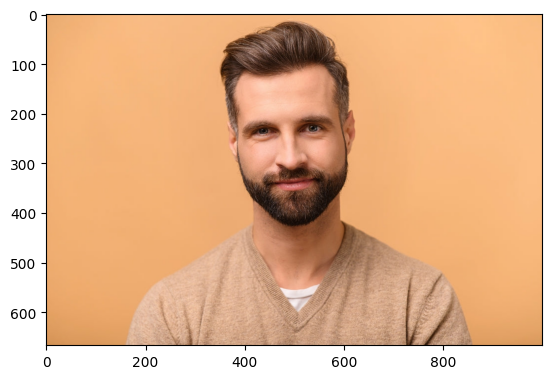

In [69]:
float_image=image.to(torch.float32)/255# because it shows rgb value
float_image.shape
plt.imshow(float_image.permute(1,2,0))

In [70]:
float_image

tensor([[[0.9176, 0.9176, 0.9176,  ..., 0.9765, 0.9765, 0.9765],
         [0.9176, 0.9176, 0.9176,  ..., 0.9765, 0.9765, 0.9765],
         [0.9176, 0.9176, 0.9176,  ..., 0.9765, 0.9765, 0.9765],
         ...,
         [0.8235, 0.8235, 0.8235,  ..., 0.8471, 0.8431, 0.8431],
         [0.8235, 0.8235, 0.8235,  ..., 0.8471, 0.8431, 0.8431],
         [0.8235, 0.8235, 0.8235,  ..., 0.8471, 0.8431, 0.8392]],

        [[0.6627, 0.6627, 0.6627,  ..., 0.7333, 0.7333, 0.7333],
         [0.6627, 0.6627, 0.6627,  ..., 0.7333, 0.7333, 0.7333],
         [0.6627, 0.6627, 0.6627,  ..., 0.7333, 0.7333, 0.7333],
         ...,
         [0.5725, 0.5725, 0.5725,  ..., 0.5961, 0.5922, 0.5922],
         [0.5725, 0.5725, 0.5725,  ..., 0.5961, 0.5922, 0.5922],
         [0.5725, 0.5725, 0.5725,  ..., 0.5961, 0.5922, 0.5882]],

        [[0.4353, 0.4353, 0.4353,  ..., 0.4941, 0.4941, 0.4941],
         [0.4353, 0.4353, 0.4353,  ..., 0.5020, 0.5020, 0.5020],
         [0.4353, 0.4353, 0.4353,  ..., 0.5020, 0.5020, 0.

##add Transform to resize
## add dimension


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(<matplotlib.image.AxesImage at 0x7d27ad5f2170>, torch.Size([3, 64, 64]))

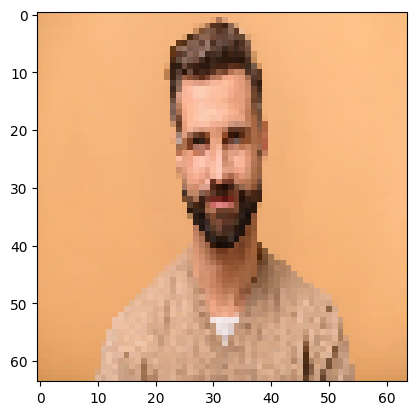

In [71]:
transformer=transforms.Resize((64,64))
transformed_image=transformer(float_image)
plt.imshow(transformed_image.permute(1,2,0)),transformed_image.shape


In [72]:
##dimension because of batch size
image_with_dimension=transformed_image.unsqueeze(dim=0)
image_with_dimension.shape

torch.Size([1, 3, 64, 64])

In [73]:
with torch.inference_mode():
  prediction=model1(image_with_dimension).squeeze()


In [74]:
prediction

tensor(-0.0171)

In [75]:
#turn logits into prediction labels
label=torch.sigmoid(prediction)
label

tensor(0.4957)

In [76]:
classes[(int)(torch.round(label).item())]# predicted correct

'adults'

In [77]:
classes

['adults', 'children']

In [78]:
import torchvision

In [79]:
torch.__version__,torchvision.__version__


('2.0.1+cu118', '0.15.2+cu118')

In [80]:
import torchinfo
from torchinfo import summary

In [81]:
model=summary(model0,input_size=[10,3,64,64])
model

Layer (type:depth-idx)                   Output Shape              Param #
Model0                                   [10, 1]                   --
├─Sequential: 1-1                        [10, 10, 31, 31]          --
│    └─Conv2d: 2-1                       [10, 10, 63, 63]          130
│    └─ReLU: 2-2                         [10, 10, 63, 63]          --
│    └─Conv2d: 2-3                       [10, 10, 62, 62]          410
│    └─MaxPool2d: 2-4                    [10, 10, 31, 31]          --
├─Sequential: 1-2                        [10, 10, 14, 14]          --
│    └─Conv2d: 2-5                       [10, 10, 30, 30]          410
│    └─ReLU: 2-6                         [10, 10, 30, 30]          --
│    └─Conv2d: 2-7                       [10, 10, 29, 29]          410
│    └─MaxPool2d: 2-8                    [10, 10, 14, 14]          --
├─Sequential: 1-3                        [10, 1]                   --
│    └─Flatten: 2-9                      [10, 1960]                --
│    └─Line

#Transfer Learning

## getting pretrained model weights and make auto transform

In [82]:
from torchvision.models import EfficientNet_B0_Weights

In [83]:
weight=EfficientNet_B0_Weights.DEFAULT
transform=weight.transforms()

In [84]:
from torchvision.datasets.imagenet import ImageFolder
Batch=32
workers=os.cpu_count()
train_data=ImageFolder(train,transform)
test_data=ImageFolder(test,transform)
##train data Loader


train_data_loader=DataLoader(train_data,
                             batch_size=Batch,
                             shuffle=True,
                             pin_memory=True,
                             num_workers=workers)

# Test Data Loader

test_data_loader=DataLoader(test_data,
                             batch_size=Batch,
                             shuffle=True,
                             pin_memory=True,
                             num_workers=workers)
len(train_data_loader),len(test_data_loader)

(22, 4)

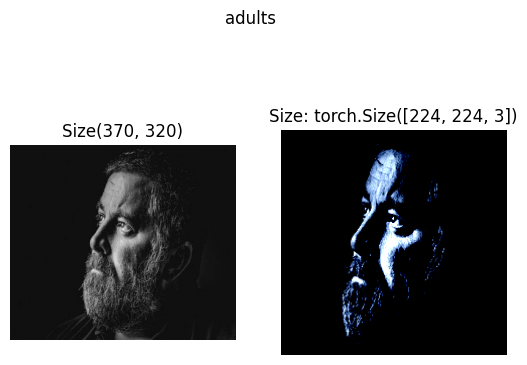

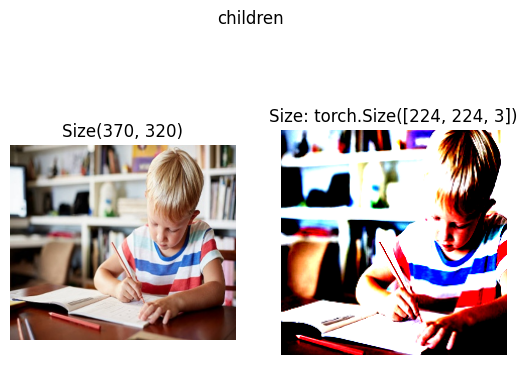

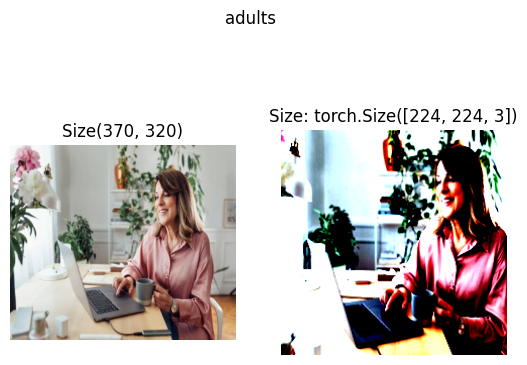

In [85]:
transform_visualization_raw(imglist,transform,32,3)

In [86]:
model=torchvision.models.efficientnet_b0()
#model

In [87]:
summ=summary(model,input_size=[32,3,224,224],col_names=["output_size","num_params","trainable"])
#summ

##setting model baseline training to false

In [88]:
for param in model.features.parameters():
    param.requires_grad=False

In [89]:
summ=summary(model,input_size=[32,3,224,224],col_names=["output_size","num_params","trainable"])
#summ

In [90]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [91]:
model.classifier=nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280,out_features=1,bias=True)
)

In [92]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1, bias=True)
)

##Train Model

In [93]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.02)

In [94]:
model=model.to(device)
accuracy=accuracy.to(device)

In [95]:
results=model_building(train_data_loader,test_data_loader,model,loss_fn,optimizer,accuracy,device,6)
results

Epoch0-----------------------------------------
trainloss : 0.7913598418235779  | trainaccuracy : 0.46590909361839294
testloss : 0.7187520265579224  | testaccuracy : 0.5026041865348816
Epoch1-----------------------------------------
trainloss : 0.7062929272651672  | trainaccuracy : 0.46022728085517883
testloss : 0.6958664655685425  | testaccuracy : 0.5078125
Epoch2-----------------------------------------
trainloss : 0.6965490579605103  | trainaccuracy : 0.5
testloss : 0.6931835412979126  | testaccuracy : 0.4921875
Epoch3-----------------------------------------
trainloss : 0.7036436200141907  | trainaccuracy : 0.5
testloss : 0.7036556005477905  | testaccuracy : 0.5052083134651184
Epoch4-----------------------------------------
trainloss : 0.7084867358207703  | trainaccuracy : 0.4857954680919647
testloss : 0.7006528377532959  | testaccuracy : 0.5078125
Epoch5-----------------------------------------
trainloss : 0.731624186038971  | trainaccuracy : 0.48295456171035767
testloss : 0.79576

{'trainloss': [0.7913598418235779,
  0.7062929272651672,
  0.6965490579605103,
  0.7036436200141907,
  0.7084867358207703,
  0.731624186038971],
 'testloss': [0.7187520265579224,
  0.6958664655685425,
  0.6931835412979126,
  0.7036556005477905,
  0.7006528377532959,
  0.7957686185836792],
 'trainaccuracy': [0.46590909361839294,
  0.46022728085517883,
  0.5,
  0.5,
  0.4857954680919647,
  0.48295456171035767],
 'testaccuracy': [0.5026041865348816,
  0.5078125,
  0.4921875,
  0.5052083134651184,
  0.5078125,
  0.4973958432674408]}

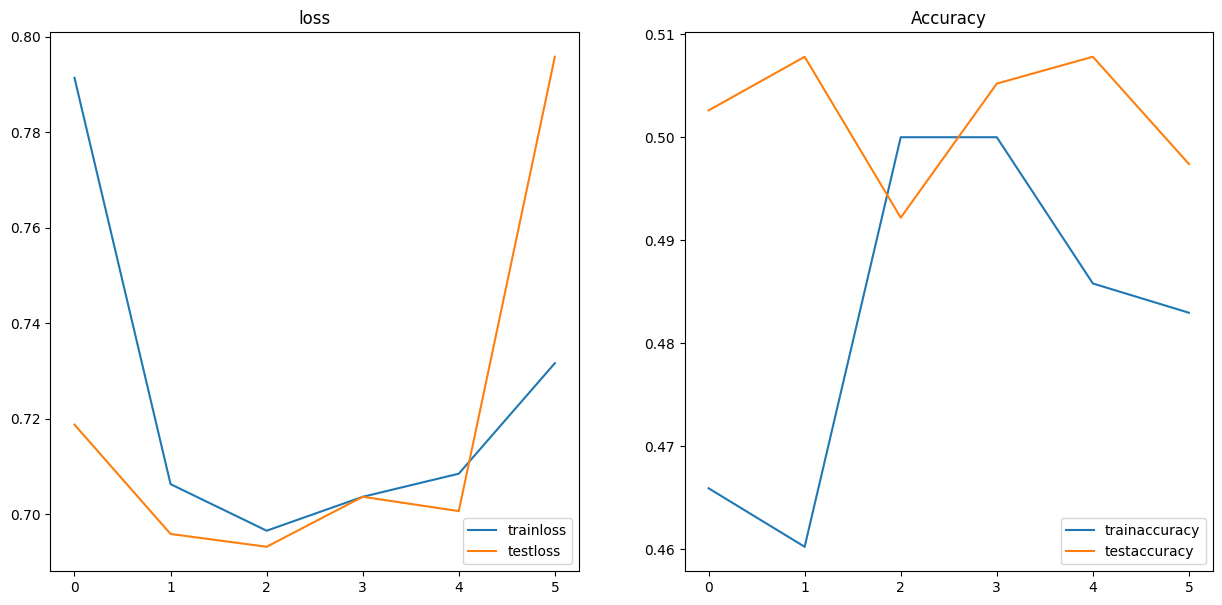

In [96]:
plot_loss_curves(results)

#Going Modular

## Creating Model

In [97]:
import os
os.makedirs("Modules")

In [98]:
%%writefile Modules/model.py
import torch
from torch import nn
class Model0(nn.Module):
  def __init__(self,input,hidden,output):
    super().__init__()

    self.block1=nn.Sequential(
        nn.Conv2d(in_channels=input,out_channels=hidden,kernel_size=2,stride=1,padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden,out_channels=hidden,kernel_size=2,stride=1,padding=0),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.block2=nn.Sequential(
        nn.Conv2d(in_channels=hidden,out_channels=hidden,kernel_size=2,stride=1,padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden,out_channels=hidden,kernel_size=2,stride=1,padding=0),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.finalLayer=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden*14*14,out_features=output)
    )
  def forward(self,x):
    x=self.block1(x)

    x=self.block2(x)

    x=self.finalLayer(x)

    return x

Writing Modules/model.py


In [99]:
from Modules import model
model1=model.Model0(3,10,1).to(device)
model

<module 'Modules.model' from '/content/Modules/model.py'>

## Creating training and testing dataloader

In [100]:
from torchinfo import summary

In [102]:
transform=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [103]:
summary(model1,input_size=[32,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
Model0                                   [32, 1]                   --
├─Sequential: 1-1                        [32, 10, 31, 31]          --
│    └─Conv2d: 2-1                       [32, 10, 63, 63]          130
│    └─ReLU: 2-2                         [32, 10, 63, 63]          --
│    └─Conv2d: 2-3                       [32, 10, 62, 62]          410
│    └─MaxPool2d: 2-4                    [32, 10, 31, 31]          --
├─Sequential: 1-2                        [32, 10, 14, 14]          --
│    └─Conv2d: 2-5                       [32, 10, 30, 30]          410
│    └─ReLU: 2-6                         [32, 10, 30, 30]          --
│    └─Conv2d: 2-7                       [32, 10, 29, 29]          410
│    └─MaxPool2d: 2-8                    [32, 10, 14, 14]          --
├─Sequential: 1-3                        [32, 1]                   --
│    └─Flatten: 2-9                      [32, 1960]                --
│    └─Line

In [104]:
%%writefile Modules/DataLoaders.py
import torchvision
from torchvision import transforms,datasets
from torch.utils.data import DataLoader
from pathlib import Path
def data_loaders_creation(trainpath:Path,
                          testpath:Path,
                          transform:torchvision.transforms,
                          batch_size):
  """
  Creating dataloaders
  Args: 1) train directory path
        2) test directory path
        3)transformer
        4) Batch Size of images
  Return :
         Train and test data loader along with classes
  """
  # datasets
  train_data=datasets.ImageFolder(
    root=trainpath,
    transform=transform#transformation
  )
  test_data=datasets.ImageFolder(
    root=testpath,#path
    transform=transform
  )
  classes=train_data.classes

  #dataloader
  train_data_loader=DataLoader(dataset=train_data,
                             batch_size=batch_size,
                             shuffle=True)
  test_data_loader=DataLoader(dataset=test_data,
                            batch_size=batch_size,
                            shuffle=False)
  #print(len(train_data_loader)," ",len(test_data_loader),classes)
  return [train_data_loader,test_data_loader,classes]



Writing Modules/DataLoaders.py


In [105]:
from Modules import DataLoaders

In [106]:
train_data_loader,test_data_loader,classes=DataLoaders.data_loaders_creation(train,test,transform,32)

In [107]:
len(train_data_loader),next(iter(train_data_loader))[0].shape

(22, torch.Size([32, 3, 64, 64]))

In [108]:
img=next(iter(train_data_loader))[0]
img.shape

torch.Size([32, 3, 64, 64])

##sample Testing

In [110]:
pred=model1(img.to(device))
torch.sigmoid(pred)

tensor([[0.4957],
        [0.4946],
        [0.4943],
        [0.4929],
        [0.4917],
        [0.4944],
        [0.4947],
        [0.4971],
        [0.4911],
        [0.4938],
        [0.4947],
        [0.4918],
        [0.4954],
        [0.4940],
        [0.4918],
        [0.4921],
        [0.4966],
        [0.4942],
        [0.4927],
        [0.4917],
        [0.4904],
        [0.4970],
        [0.4893],
        [0.4902],
        [0.4946],
        [0.4921],
        [0.4921],
        [0.4953],
        [0.4924],
        [0.4985],
        [0.4943],
        [0.4946]], device='cuda:0', grad_fn=<SigmoidBackward0>)

##Training and testing

In [111]:
%%writefile Modules/builder.py
import torch
from torch import nn
from torchmetrics import Accuracy
from torch.utils.data import DataLoader
def training(data:torch.utils.data.DataLoader,
             model:torch.nn.Module,
             device,
             accuracy:Accuracy,
             loss_fn,
             optimizer:torch.optim):
  trainloss,trainaccuracy=0,0
  for x,y in data:
    x,y=x.to(device),y.to(device)
    y_pred=model(x).squeeze()
    loss=loss_fn(y_pred,y.float())
    trainloss+=loss
    trainaccuracy+=accuracy(y,torch.round(torch.sigmoid(y_pred)))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return trainloss/len(data),trainaccuracy/len(data)

def testing(data:torch.utils.data.DataLoader,
            model:torch.nn.Module,
            loss_fn,
            accuracy,device):

  model.eval()

  with torch.inference_mode():
    testloss,testaccuracy=0,0
    for x,y in data:
      x,y=x.to(device),y.to(device)
      y_pred=model(x).squeeze()
      loss=loss_fn(y_pred,y.float())
      testloss+=loss
      testaccuracy+=accuracy(y,torch.round(torch.sigmoid(y_pred)))
  return testloss/len(data),testaccuracy/len(data)
def model_building(train_data:torch.utils.data.DataLoader,
                   test_data:torch.utils.data.DataLoader,
                   model:torch.nn.Module,
                   loss_fn,
                   optimizer:torch.optim,
                   accuracy,
                   device,
                   epochs):
  model=model.to(device)
  results={
      'trainloss':[],
      'testloss':[],
      'trainaccuracy':[],
      'testaccuracy':[]
  }
  for epoch in range(epochs):
    print(f"Epoch{epoch}-----------------------------------------")
    trainloss,trainaccuracy=training(train_data,model,device,accuracy,loss_fn,optimizer)

    testloss,testaccuracy =testing(test_data,model,loss_fn,accuracy,device)

    print(f"trainloss : {trainloss}  | trainaccuracy : {trainaccuracy}")
    print(f"testloss : {testloss}  | testaccuracy : {testaccuracy}")
    results['trainloss'].append(trainloss.item())
    results['testloss'].append(testloss.item())
    results['trainaccuracy'].append(trainaccuracy.item())
    results['testaccuracy'].append(testaccuracy.item())
  return results

Writing Modules/builder.py


In [112]:
from Modules import builder
from timeit import default_timer as timer

In [117]:
loss_fn=nn.BCEWithLogitsLoss()
model1=model.Model0(3,10,1)
optimizer=torch.optim.SGD(model1.parameters(),lr=0.002)
start=timer()

results=builder.model_building(train_data_loader,test_data_loader,model1,
                               loss_fn,optimizer,accuracy,device,6)
end=timer()
print(f"Total Time{end-start:.2f}")

Epoch0-----------------------------------------
trainloss : 0.6934401392936707  | trainaccuracy : 0.5
testloss : 0.6944574117660522  | testaccuracy : 0.46875
Epoch1-----------------------------------------
trainloss : 0.6931130290031433  | trainaccuracy : 0.5028409361839294
testloss : 0.6941820979118347  | testaccuracy : 0.4973958432674408
Epoch2-----------------------------------------
trainloss : 0.6930931210517883  | trainaccuracy : 0.5014204978942871
testloss : 0.6940392851829529  | testaccuracy : 0.4895833432674408
Epoch3-----------------------------------------
trainloss : 0.693089485168457  | trainaccuracy : 0.5
testloss : 0.6938489675521851  | testaccuracy : 0.4505208432674408
Epoch4-----------------------------------------
trainloss : 0.6931360363960266  | trainaccuracy : 0.5071023106575012
testloss : 0.6935833692550659  | testaccuracy : 0.4661458432674408
Epoch5-----------------------------------------
trainloss : 0.6930408477783203  | trainaccuracy : 0.4886363744735718
testl

#model `Saving`

In [125]:
def save_model(model:torch.nn,
               path:Path,
               modelname:str):
  path=Path(path)

  assert modelname.endswith(".pth"),"Modelname should ends with .pth"
  path.mkdir(parents=True,exist_ok=True)
  targetpath=path/modelname
  print("Saving model....")
  torch.save(obj=model.state_dict(),f=targetpath)
  print("model saved")

In [126]:
save_model(model1,"models","Tiny_VGG_Model1.pth")

Saving model....
model saved
